<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multicollearity" data-toc-modified-id="Multicollearity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multicollearity</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Maximum-Likelihood---Primer" data-toc-modified-id="Maximum-Likelihood---Primer-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Maximum Likelihood - Primer</a></span></li><li><span><a href="#Maximum-Likelihood---Linear-Regression" data-toc-modified-id="Maximum-Likelihood---Linear-Regression-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Maximum Likelihood - Linear Regression</a></span></li></ul></li><li><span><a href="#R-squared" data-toc-modified-id="R-squared-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>R-squared</a></span></li><li><span><a href="#Variance-Inflation-Factor" data-toc-modified-id="Variance-Inflation-Factor-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Variance Inflation Factor</a></span></li><li><span><a href="#Cramer's-V" data-toc-modified-id="Cramer's-V-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Cramer's V</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style()

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

%watermark -a 'Ethen' -d -t -v -p scipy,numpy,pandas,sklearn,matplotlib

Ethen 2017-12-23 09:28:58 

CPython 3.5.2
IPython 6.2.1

scipy 1.0.0
numpy 1.13.3
pandas 0.20.3
sklearn 0.19.1
matplotlib 2.1.0


# Multicollearity

Many machine learning models have either some inherent internal ranking of features or it is not extremely complicated to generate/access the ranking from the structure of the model. This document discusses the issue of multicollinearity, i.e. how multicollinearity can affect the feature ranking and potential methods that can be used to address them. As we'll be looking at the coefficients of linear regression model for selecting and interpreting features, the next section contains a introduction to this method/algorithm.


## Linear Regression

Unlike a lot of other tutorials, we'll introduce linear regression from a **maximum likelihood** perspective. The principle of maximum likelihood is at the heart of machine learning. It guides us to find the best model in a search space of all models. In simple terms, Maximum Likelihood Estimation (MLE) lets us choose a model (parameters) that explains the data (training set) better than all other models.

### Maximum Likelihood - Primer

The process of sampling from a normal distribution is expressed as, $x \sim \mathcal{N}(\mu, \sigma^{2})$. $x$ is a random variable sampled or generated or simulated from the gaussian distribution. As we sample from this distribution, most samples will fall around the center, near the mean, because of higher probability density in the center.

<img src="img/normal_random_sample.png" width="60%" height="60%">

Let's consider 3 data points, $y1=1,y2=0.5,y3=1.5$, which are independent and drawn from a gaussian with unknown mean $\theta$ and constant variance of 1. Suppose we now have two choices for $\theta$: {1, 2.5}. Which one should we choose? Which model $\theta$ would explain the data better? In general, any data point drawn from a gaussian with mean $\theta$ and and variance 1, can be written as,

$$
\begin{align}
y_i \sim \mathcal{N}(\theta, 1) = \theta + \mathcal{N}(0,1)
\end{align}
$$

This can be read as $\theta$ the mean, shifts the center of the standard normal distribution ($\mu = 0$ and $\sigma^2=1$) The likelihood of data (y1,y2,y3) having been drawn from $\mathcal{N}(\theta,1)$, can be expressed as:

$$
\begin{align}
P(y1,y2,y3 \vert \theta) = P(y1 \vert \theta) P(y2 \vert \theta) P(y3 \vert \theta)
\end{align}
$$

as the data points are assumed to be independent of one another.

Now, we have two normal distributions defined by $\theta = 1$ and $\theta = 2.5$. Let us draw both and plot the data points. In the figure below, notice the dotted lines that connect the bell curve to the data points. Consider the point $y2=0.5$ in the first distribution $\mathcal{N}(\mu=1, \sigma^2=1)$. The length of the dotted line gives the probability of the $y2=0.5$ being drawn from $\mathcal{N}(\mu=1, \sigma^2=1)$. And the same goes for the second distribution $\mathcal{N}(\mu=2.5, \sigma^2=1)$.

<img src="img/two_normal_sample.png" width="60%" height="60%">

Knowing that the likelihood of data (y1,y2,y3) having been drawn from $\mathcal{N}(\mu=1,\sigma^2=1)$ is given by:

$$
\begin{align}
P(y1,y2,y3 \vert \theta=1) = P(y1 \vert \theta=1) P(y2 \vert \theta=1) P(y3 \vert \theta=1)
\end{align}
$$

The individual probabilities in the equation above are equal to the heights of corresponding dotted lines in the figure. We see that the likelihood, computed by the product of individual probabilities of data points given model, is essentially the product of lengths of dotted lines. In this toy example, the likelihood of model $\theta = 1$ seems to higher than $\theta = 2.5$, so that's the model we'll be going with.

### Maximum Likelihood - Linear Regression

For linear regression we assume the relationship between our input variable $X$ and our output label $Y$ can be modeled by a linear function.

$$
\begin{align}
Y = \theta_0 + \theta_1X_1 + \theta_2X_2 + \ldots + \theta_pX_p + \epsilon
\end{align}
$$

The model assumes the label for each observation, $y_i$, is gaussian distributed with mean, $x_i^T\theta$ and variance, $\sigma^2$, which can be written as:

$$
\begin{align}
y_i &= \mathcal{N}(x_i^{T}\theta, \sigma^{2}) = x_i^{T}\theta + \mathcal{N}(0, \sigma^{2})\\
prediction, \hat{y_i} &= x_i^T\theta
\end{align}
$$

The mean $x_i^{T}\theta$ represents the best fitted line with all data points varying around that line, and the term $\epsilon$, captures this varying variance $\mathcal{N}(0, \sigma^{2})$.

<img src="img/linear_regression.png" width="60%" height="60%">

Now, recall that the formula for the gaussian/normal distribution is:

$$
\begin{align}
p(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2}
\end{align}
$$

Given that linear regression assumes each point $y_i$ to be gaussian distributed, the process of learning becomes the process of maximizing the product of the individual probabilities:

$$
\begin{align}
p(y \vert X, \theta, \sigma)
&= \prod_{i=1}^{n} p(y_i \vert x_i, \theta, \sigma) \\
&= \prod_{i=1}^{n} (2\pi\sigma^2)^{-1/2} e^{-\frac{1}{2\sigma^2}(y_i - x_i^T\theta)^2}
\end{align}
$$

Next we rewrite the equation in vector form and due to the fact that the original maximization problem is equivalent to maximizing its log likelihood (log is a monotonic transformation thus does not affect that learned parameters). Thus we take the log to make the derivation later easier.

$$
\begin{align}
p(y \vert X, \theta, \sigma)
&= (2\pi\sigma^2)^{-n/2} e^{-\frac{1}{2\sigma^2}(y - X\theta)^2} \\
&= -\frac{n}{2}log(2\pi\sigma^2) -\frac{1}{2\sigma^2}(y-X\theta)^2
\end{align}
$$

Our current interest right now is to solve for the unknown parameter $\theta$ (we can use similar idea to solve for the unknown $\sigma$), thus we can further simplify the equation above, to remove all the terms that are not relevant to $\theta$, and in machine learning problems, we're often interested in minimizing the objective function, thus we negate the negative sign and turn the maximization problem into a minimization one.

$$
\begin{align}
L = \frac{1}{2}(y-X\theta)^2
\end{align}
$$

When introducing linear regression, an alternative way of viewing it is from a least squares perspective. The objective of least squares is to minimize the squared distance between the prediciton and the ground truth. So, we want to minimize the mean squared error: $\frac{1}{2} (y - X\theta)^2$. We now see that we can come to the same objective from two different perspective. The following section lists out the derivation for solving $\theta$.

We'll first expand this equation:

$$
\begin{align}
L &= \frac{1}{2} (y - X\theta)^2 \\
  &= \frac{1}{2} (y - X\theta)^T(y - X\theta) \\
  &= \frac{1}{2} (y^Ty - 2\theta^TX^Ty + \theta^TX^TX\theta)
\end{align}
$$

Using the standard rule of minimization in calculus, if we wish to solve for the weight $\theta$, we would take the derivative w.r.t. $\theta$ and set it to zero.

$$
\begin{align}
\frac{\partial}{\partial{\theta}} \frac{1}{2} (y^Ty - 2\theta^TX^Ty + \theta^TX^TX\theta) &= 0 \\
\frac{1}{2} (2X^Ty - 2X^TX\theta) &= 0 \\
X^Ty - X^TX\theta &= 0
\end {align}
$$

In the steps above, $y^Ty$ vanished as there’s no $\theta$ dependence, and $\theta^TX^TX\theta$ becomes $2X^TX\theta$ as $\theta^T\theta$ is analogous to $\theta^2$. As the final step, we will perform some rearrangement of the formula:

$$
\begin{align}
X^Ty - X^TX\theta &= 0 \\
X^TX\theta &= X^Ty \\
\theta &= (X^TX)^{-1}X^Ty
\end {align}
$$

Matrix calculus can feel a bit handwavy sometimes, if you're not convinced by the derivation above, the following link walks through each individual steps in much more detail. [Blog: The Normal Equation and matrix calculus](https://eli.thegreenplace.net/2015/the-normal-equation-and-matrix-calculus/)

---

After solving for the coefficients of the regression model, we can use it for selecting and interpreting features, if all features are on the same scale, the most important features should have the highest coefficients in the model, while features uncorrelated with the output variables should have coefficient values close to zero. This approach can work well when the data is not very noisy (or there is a lot of data compared to the number of features) and the features are (relatively) independent:

In [3]:
# sklearn's LinearRegression may give harmless errors
# https://github.com/scipy/scipy/issues/5998
warnings.filterwarnings(
    action = 'ignore', module = 'scipy', message = '^internal gelsd')
 

def pretty_print_linear(estimator, names = None, sort = False):
    """A helper method for pretty-printing linear models' coefficients"""
    coef = estimator.coef_
    if names is None:
        names = ['X%s' % x for x in range(1, len(coef) + 1)]

    info = zip(coef, names)
    if sort:
        info = sorted(info, key = lambda x: -np.abs(x[0]))
    
    output = ['{} * {}'.format(round(coef, 3), name) for coef, name in info]
    output = ' + '.join(output)
    return output
 

# A dataset with 3 features
size = 5000
np.random.seed(0)
X = np.random.normal(0, 1, (size, 3))

# y = X0 + 2 * X1 + noise
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(0, 2, size)
linear = LinearRegression()
linear.fit(X, y)
print('Linear model:', pretty_print_linear(linear))

Linear model: 0.984 * X1 + 1.995 * X2 + -0.041 * X3


As we can see in this example, the model indeed recovers the underlying structure of the data very well, despite quite significant noise in the data. Given that the the predictors are on the same scale, we can compare the coefficients directly to determine variable importance, we can see here that when using linear regression, X2 is the most important predictor for this given dataset. To be explicit, standardized coefficients represent the mean change in the response given one standard deviation change in the predictor.


## R-squared

After fitting our predictive model, we would most likely wish to evaluate its performance and **R-squared** is a statistic that is often used to evaluate a regression model's performance. It takes a value ranging from 0 to 1 and is usually interpreted as summarizing the percent of variation in the response that the regression model is capable of explaining. So a R-squared of 0.65 means the model explains about 65% of the variation in our dependent variable. Given this logic, we prefer our regression models have a high R-squared, since we want the model we've trained to capture the output's variance as much as possible. One way to compute R-squared is the sum of squared fitted-value deviations divided by the sum of squared original-value deviations:

$$
\begin{align}
R^{2} =  \frac{\sum (\hat{y} - \bar{\hat{y}})^{2}}{\sum (y - \bar{y})^{2}}
\end{align}
$$

- $y$: original reponse variable.
- $\hat{y}$: predicted value for the reponse variable.
- $\bar{y}$: The average of reponse variable (pronounced as y bar).

An alternative form is:

$$
\begin{align}
R^2 = 1 - \frac{RSS}{TSS} = 1- \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}
\end{align}
$$

- RSS: Stands for Residual Sum of Squares or referred to as sum of squared error (the measurement that linear model tries of minimize). This value captures the variance that is left between our prediction and the actual values of the output.
- TSS: Stands for Total Sum of Squares, which measures the total variance in the output variable.

In [4]:
def rsquared_score(y_true, y_pred):
    """rsquared evaluation metric"""
    rss = np.sum((y_true - y_pred) ** 2)
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    rsquared = 1 - rss / tss
    return rsquared


y_pred = linear.predict(X)
print('rsquared:', rsquared_score(y, y_pred))

# we can use scikit-learn's r2_score function
# by passing in the predicted value and the true label
print('rsquared:', r2_score(y, y_pred))

# or for regression models, the default evaluation
# metric is set to be rsquared and can be accessed
# through the .score method
print('rsquared:', linear.score(X, y))

rsquared: 0.551603126683
rsquared: 0.551603126683
rsquared: 0.551603126683


Though widely used, this is actually a measurement that requires some context for it to be a valid evaluation metric. We'll give some examples of why:

> R-squared can be arbitrarily close to 1 when the model is totally wrong.

rsquared: 0.899545630046


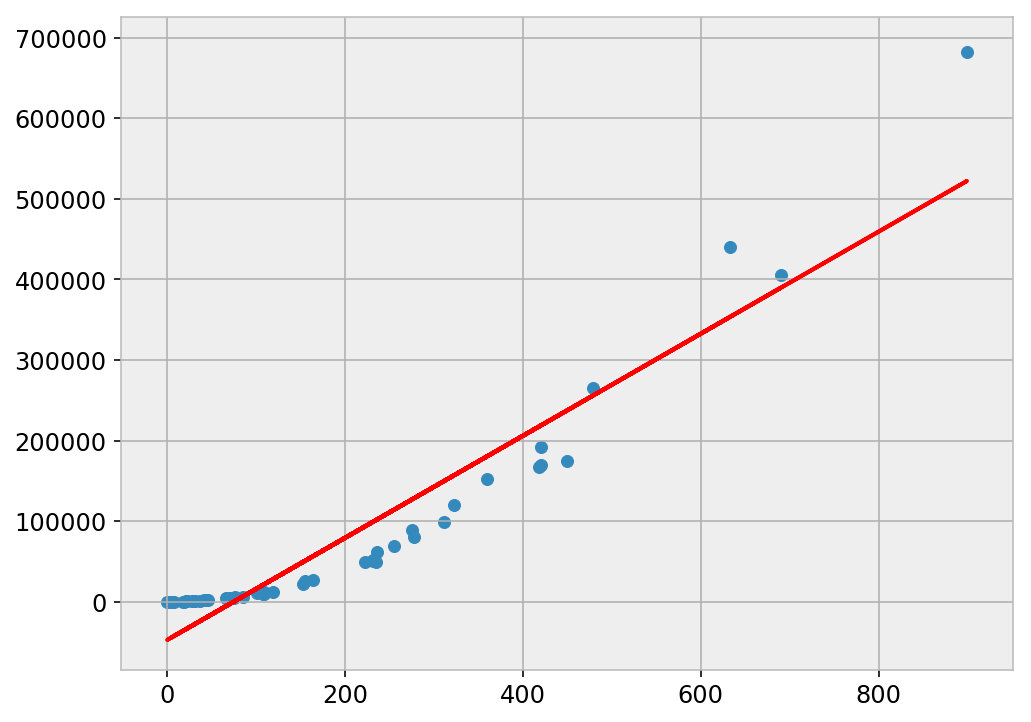

In [5]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# generate some exponential data and fit a linear regression to it
rstate = np.random.RandomState(1)
x = rstate.exponential(scale = 1 / 0.005, size = 50)
y = (x - 1) ** 2 * rstate.uniform(low = 0.8, high = 1.2, size = 50)

# scikit-learn model expects a 2d ndarray
# even if the data only contains 1 feature
X = x.reshape(-1, 1)
linear = LinearRegression()
linear.fit(X, y)
print('rsquared:', linear.score(X, y))

y_pred = linear.predict(X)
plt.plot(x, y_pred, 'r')
plt.scatter(x, y)
plt.show()

When checking the R-squared value for this model, it’s very high at about 0.90, but the model is completely wrong as this data follows a nonlinear distribution. Using R-squared to justify the "goodness" of our model in this instance would be a mistake. Hopefully one would plot the data first and recognize that a simple linear regression in this case would be inappropriate.

> We’re better off using Mean Square Error (MSE) or other error-based metric as a measure of prediction error. As R-squared can be anywhere between 0 and 1 just by changing the range of X.

Let’s demonstrate this statement by first generating data that meets all simple linear regression assumptions and then regressing y on x to assess both R-squared and MSE.

rsquared: 0.939955704786
mse: 0.652556072211


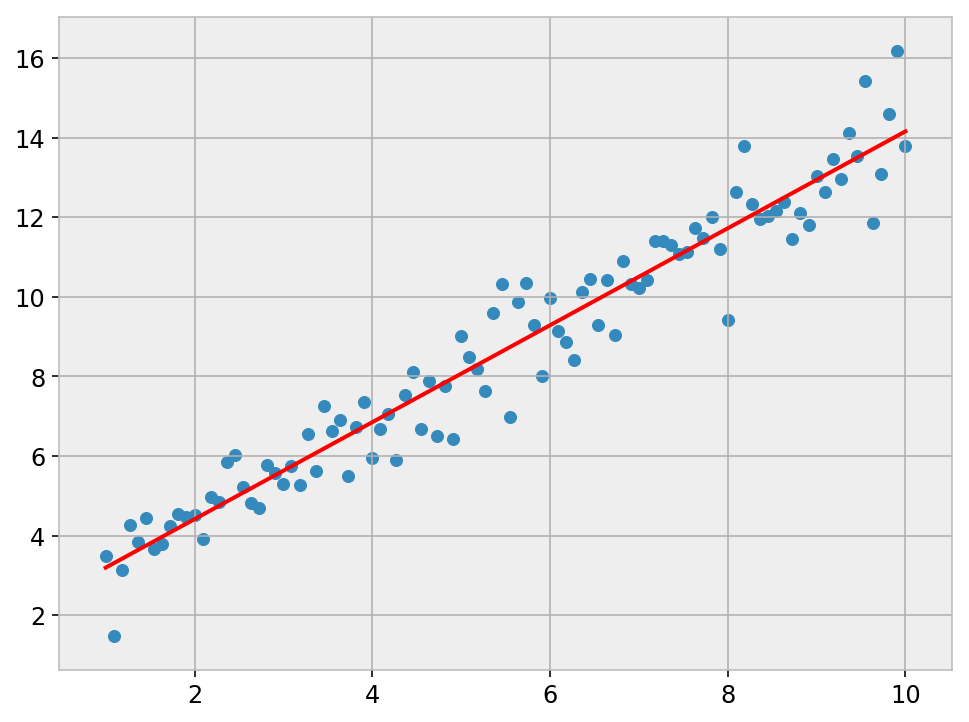

In [6]:
x = np.linspace(1, 10, 100)
y = 2 + 1.2 * x + rstate.normal(loc = 0, scale = 0.9, size = 100)
X = x.reshape(-1, 1)
linear = LinearRegression()
linear.fit(X, y)

y_pred = linear.predict(X)
print('rsquared:', r2_score(y, y_pred))
print('mse:', mean_squared_error(y, y_pred))

plt.plot(x, y_pred, 'r')
plt.scatter(x, y)
plt.show()

We repeat the above code, but this time with a different range of x. Leaving everything else the same:

rsquared: 0.113636419988
mse: 0.853185480419


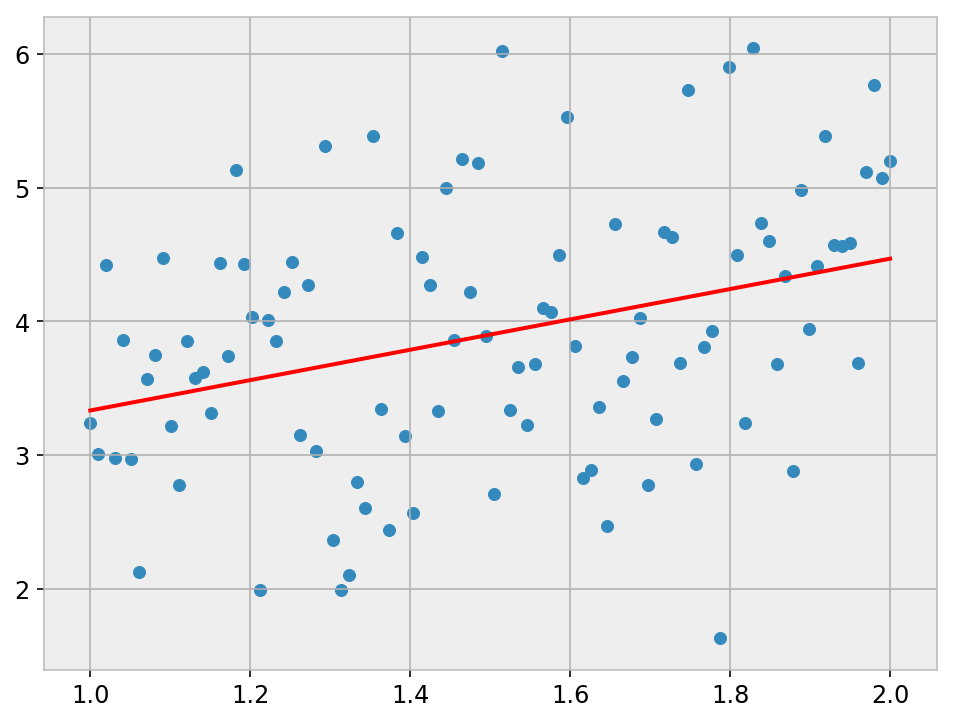

In [7]:
# smaller range for x
x = np.linspace(1, 2, 100)
y = 2 + 1.2 * x + rstate.normal(loc = 0, scale = 0.9, size = 100)
X = x.reshape(-1, 1)
linear = LinearRegression()
linear.fit(X, y)

y_pred = linear.predict(X)
print('rsquared:', r2_score(y, y_pred))
print('mse:', mean_squared_error(y, y_pred))

plt.plot(x, y_pred, 'r')
plt.scatter(x, y)
plt.show()

R-squared falls from around 0.9 to around 0.2, but the MSE remains fairly the same. In other words the predictive ability is the same for both data sets, but the R-squared would lead you to believe the first example somehow had a model with more predictive power.

---

The problem we just tackled was particularly well suited for a linear model: purely linear relationship between features and the response variable, and no correlations between features. The issue arises when there are multiple (linearly) correlated features (as is the case with very many real life datasets), the model then becomes unstable, meaning small changes in the data can cause large changes in the model (i.e. coefficient values), making model interpretation very difficult.

For example, assume we have a dataset where the "true" model for the data is $Y = X1 + X2$, while we observe $\hat{Y} = X1 + X2 + \epsilon$, with $\epsilon$ being the error term. On top of that let's say $X1$ and $X2$ are linearly correlated such that $X1 \approx X2$. Ideally the learned model will be $Y = X1 + X2$. But depending on the amount of noise $\epsilon$, the amount of data at hand and the correlation between $X1$ and $X2$, it could also be $Y = 2X1$ (i.e. using only $X1$ as the predictor) or $Y = −X1 + 3X2$ (shifting of the coefficients might happen to give a better fit in the noisy training set) etc.

In [8]:
def generate_random_data(size, seed):
    """Example of collinear features existing within the data"""
    rstate = np.random.RandomState(seed)
    X_seed = rstate.normal(0, 1, size)
    X1 = X_seed + rstate.normal(0, .1, size)
    X2 = X_seed + rstate.normal(0, .1, size)
    X3 = X_seed + rstate.normal(0, .1, size)
    y = X1 + X2 + X3 + rstate.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
    return X, y
    

seed = 5
size = 100
X, y = generate_random_data(size, seed)

linear = LinearRegression()
linear.fit(X, y)
print('Linear model:', pretty_print_linear(linear))
print('rsquared:', linear.score(X, y))

Linear model: -1.291 * X1 + 1.591 * X2 + 2.747 * X3
rsquared: 0.907885896631


The coefficients of our fitted linear model sums up to ~3, so we can expect it to perform well. On the other hand, if we were to interpret the coefficients at face value, then according to the model $X3$ has a strong positive impact on the output variable, while $X1$ has a negative one, when in fact all the features are correlated and should have equal effects to the output variable. This multicollearity issue also applies to other methods/algorithms and should be addressed before feeding our data to a machine learning method/algorithm.

## Variance Inflation Factor

One of the most widely used statistical measure of detecting multicollinearity amongst numerical variable is the **Variance Inflation Factor (VIF)**. The VIF may be calculated for each predictor by performing a linear regression of that predictor on all the other predictors, i.e. if we wish to calculate the VIF for predictor $x_k$, then we would use that column as the response variable and use all other columns excluding $x_k$ as the input. After fitted the linear regression, we would then obtain the rsquared value, $R^2$, which tells us how much variance in our predictor $x_k$ can be explained by all the other predictors. Lastly the VIF can be computed using:

$$
\begin{align}
VIF = \frac{1}{1 - R^2}
\end{align}
$$

It’s called the variance inflation factor because it estimates how much the variance of a coefficient is "inflated" because of linear dependence with other predictors. Thus, a VIF of 1.8 tells us that the variance (the square of the standard error) of a particular coefficient is 80% larger than it would be if that predictor was completely uncorrelated with all the other predictors.

In [9]:
def remove_collinearity(X, colnames = None, threshold = 5.0):
    """
    Identify multi-collinearity between the numeric variables
    using variance inflation factor (vif)
    """
    if colnames is None:
        colnames = ['feature' + str(j) for j in range(1, X.shape[1] + 1)]

    while True:
        n_features = X.shape[1]
        if n_features == 1:
            break

        vif = [compute_vif(X, index) for index in range(n_features)]
        max_index = np.argmax(vif)
        if vif[max_index] >= threshold:
            removed = colnames[max_index]
            colnames.remove(removed)
            X = np.delete(X, max_index, axis = 1)
        else:
            break

    return X, colnames


def compute_vif(X, target_index):
    """
    Similar implementation as statsmodel's variance_inflation_factor
    with some enhancemants:
    1. includes the intercept by default
    2. prevents float division errors (dividing by 0)

    References
    ----------
    http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
    """
    n_features = X.shape[1]
    X_target = X[:, target_index]
    mask = np.arange(n_features) != target_index
    X_not_target = X[:, mask]

    linear = LinearRegression()
    linear.fit(X_not_target, X_target)
    rsquared = linear.score(X_not_target, X_target)
    vif = 1. / (1. - rsquared + 1e-5)
    return vif

In [10]:
# removing collinearity, thus redundant features
# while still retaining predictive power
X, colnames = remove_collinearity(X)
print('remaining feature:', colnames)

linear = LinearRegression()
linear.fit(X, y)
print('Linear model:', pretty_print_linear(linear))
print('rsquared:', linear.score(X, y))

remaining feature: ['feature3']
Linear model: 3.024 * X1
rsquared: 0.903735567258


## Cramer's V

Now that we've discussed the method for detecting collinearity amongst numerical variables, we will shift our gears towards categorical variables. **Cramer’s V** is a statistic measuring the strength of association or dependency between two (nominal) categorical variables.

Suppose $X$ and $Y$ are two categorical variables that are to be analyzed in a some experimental or observational data with the following information: 

- $X$ has $M$ distinct categories or classes, labeled $X_1,\ldots,X_M$.
- $Y$ has $N$ distinct categories, labeled $Y_1,\ldots,Y_N$.
- Form a $M\times N$ contingency table such that cell $(i,j)$ contains the count $n_{ij}$ of occurrences of category $X_i$ in $X$ and category $Y_j$ in $Y$. This would give us $n$ total pairs of observations.

We start of with the null hypothesis that $X$ and $Y$ are independent random variables, then based on the table and the null hypothesis, the chi-squared statistic $\chi^2$ can be computed. After that, Cramer's V is defined to be:

$$
\begin{align}
V=V(X,Y)=\sqrt{\frac{\chi^2}{n\operatorname{min}(M-1,N-1)}}
\end{align}
$$

Remarks:

- $0\leq V\leq 1$.  The closer $V$ is to 0, the smaller the association between the categorical variables $X$ and $Y$.  On the other hand, $V$ being close to 1 is an indication of a strong association between $X$ and $Y$. If $X=Y$, then $V(X,Y)=1$.
- In order for $V$ to make sense, each categorical variable must have at least 2 categories.
- If one of the categorical variables is dichotomous, i.e. either $M$ or $N=2$, Cramer's V is equal to the **phi statistic** ($\Phi$), which is defined to be $\Phi=\sqrt{\frac{\chi^2}{n}}$.
- Cramer's V is a chi-square based measure of association. The chi-square value depends on the strength of the relationship and sample size, while eliminates the sample size by dividing chi-square by $n$, the sample size, and taking the square root.

In [11]:
# generate a correlated categorical variable
# and see if cramer's v method will detect it
df = pd.DataFrame(index = range(1, 8))
df['a'] = ['chicken', 'chicken', 'chicken', 'chicken', 'chat', 'chat', 'chat']
df['b'] = ['dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat']
observed = pd.crosstab(df['a'], df['b'])
observed

b,cat,dog
a,,
chat,3,0
chicken,0,4


In [12]:
def compute_cramersv(observed, correction = False):
    """
    Parameters
    ----------
    observed : 2d ndarray
        The contingency table. The table contains the observed frequencies
        (i.e. number of occurrences) for each category.

    correction : bool, default False
        If True, and the degrees of freedom is 1, apply Yates’ correction for continuity.
        The effect of the correction is to adjust each observed value by 0.5 towards the
        corresponding expected value. This is set to False by defualt as the effect of
        Yates' correction is to prevent overestimation of statistical significance for small
        data. i.e. It is chiefly used when at least one cell of the table has an expected
        count smaller than 5. And most people probably aren't working with a data size that's
        that small.

    Returns
    -------
    cramersv : float
    """
    n_obs = observed.sum()
    n_row, n_col = observed.shape
    chi2 = chi2_contingency(observed, correction = correction)[0]
    cramersv = np.sqrt(chi2 / (n_obs * min(n_row - 1, n_col - 1)))
    return cramersv


correction = False
observed = observed.values
compute_cramersv(observed, correction)

1.0

# Reference


- [Blog: Cramer’s V](http://planetmath.org/cramersv)
- [Blog: Is R-squared Useless?](http://data.library.virginia.edu/is-r-squared-useless/)
- [Blog: Deriving normal equation](https://wiseodd.github.io/techblog/2017/04/14/normal-equation/)
- [Blog: The Principle of Maximum Likelihood](http://suriyadeepan.github.io/2017-01-22-mle-linear-regression/)
- [Blog: The Normal Equation and matrix calculus](https://eli.thegreenplace.net/2015/the-normal-equation-and-matrix-calculus/)
- [Blog: When Can You Safely Ignore Multicollinearity?](https://statisticalhorizons.com/multicollinearity)
- [Blog: Selecting good features – Part II: linear models and regularization
](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/)
- [Blog: How to Identify the Most Important Predictor Variables in Regression Models](http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-identify-the-most-important-predictor-variables-in-regression-models)
- [Github: Duplicate (and highly correlated) categoricals](https://github.com/JosPolfliet/pandas-profiling/issues/40)